# 0716325 曾正豪

In [1]:
import csv
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Data Input & Data Preprocessing
    在這邊，我使用了csv module來讀取學生們的資料，在讀取每一個row時，我會根據categorical與numerical的feature先分開為兩個list方便我後面做處理，在label這邊，我根據slides上頭的規則進行labeling。
    最後，我將categorical的feature做one hot encoding，並將numerical的feature接回到categorical的feature後面，形成完整的dataset

In [2]:
x = []
x_numer = []
y_binary = []
y_5_level = []
first = 0

with open('student-mat.csv', newline='') as csvfile:
  rows = csv.reader(csvfile, delimiter = ';')
  for row in rows:
    if first == 0:
        first = 1
        continue
    
    x_numer.append([row[2], row[6], row[7], row[12], row[13], row[14]])
    x_numer[-1].extend(row[23:-1])
    x.append(row[0:2])
    x[-1].extend(row[3:6])
    x[-1].extend(row[8:12])
    x[-1].extend(row[15:23])
    
    G3 = int(row[-1])
    if G3 >= 10:
        y_binary.append('PASS')
    else:
        y_binary.append('FAIL')
    
    if G3 >= 16:
        y_5_level.append('A')
    elif G3 >= 14:
        y_5_level.append('B')
    elif G3 >= 12:
        y_5_level.append('C')
    elif G3 >= 10:
        y_5_level.append('D')
    else:
        y_5_level.append('F')
#print(x_numer[1])
#print(x[1])
#print(len(y_binary), len(y_5_level))
y_binary = np.array(y_binary)
y_5_level = np.array(y_5_level)

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
enc.fit(x)
x = enc.transform(x)
x = np.append(x, x_numer, axis=1)
x = np.array(x, dtype=np.float64)

In [3]:
pca = PCA(n_components=2)

# PCA + Decision Tree
    這邊我使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為PCA以及Decision Tree"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。

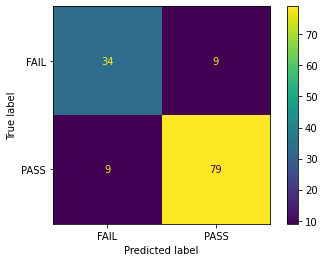

              precision    recall  f1-score   support

        FAIL       0.79      0.78      0.79       130
        PASS       0.89      0.90      0.90       265

    accuracy                           0.86       395
   macro avg       0.84      0.84      0.84       395
weighted avg       0.86      0.86      0.86       395



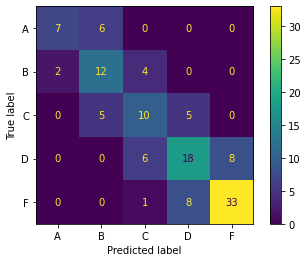

              precision    recall  f1-score   support

           A       0.72      0.53      0.61        40
           B       0.51      0.62      0.56        60
           C       0.45      0.50      0.47        62
           D       0.58      0.54      0.56       103
           F       0.80      0.78      0.79       130

    accuracy                           0.62       395
   macro avg       0.61      0.59      0.60       395
weighted avg       0.63      0.62      0.63       395



In [4]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

    decision_tree_bin = tree.DecisionTreeClassifier()
    decision_tree_5l  = tree.DecisionTreeClassifier()

    decision_tree_bin = decision_tree_bin.fit(X_train, y_binary_train)
    decision_tree_5l  = decision_tree_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = decision_tree_bin.predict(X_test)
    y_5_level_pred = decision_tree_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_5l.classes_).plot()
plt.show()
print(report)



# without PCA + Decision Tree
    這邊我使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為Decision Tree"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。

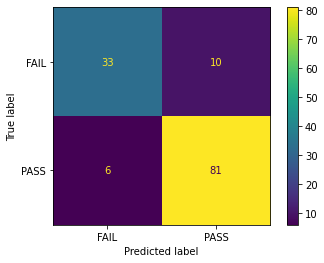

              precision    recall  f1-score   support

        FAIL       0.83      0.76      0.80       130
        PASS       0.89      0.92      0.91       265

    accuracy                           0.87       395
   macro avg       0.86      0.84      0.85       395
weighted avg       0.87      0.87      0.87       395



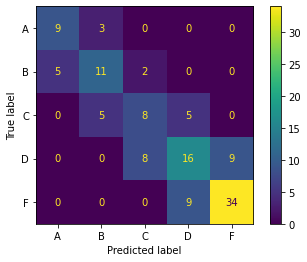

              precision    recall  f1-score   support

           A       0.61      0.68      0.64        40
           B       0.55      0.58      0.56        60
           C       0.44      0.42      0.43        62
           D       0.52      0.48      0.50       103
           F       0.77      0.79      0.78       130

    accuracy                           0.61       395
   macro avg       0.58      0.59      0.58       395
weighted avg       0.60      0.61      0.60       395



In [5]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    decision_tree_bin = tree.DecisionTreeClassifier()
    decision_tree_5l  = tree.DecisionTreeClassifier()

    decision_tree_bin = decision_tree_bin.fit(X_train, y_binary_train)
    decision_tree_5l  = decision_tree_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = decision_tree_bin.predict(X_test)
    y_5_level_pred = decision_tree_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=decision_tree_5l.classes_).plot()
plt.show()
print(report)



# PCA + Random Forest
    這邊我使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為PCA以及Random Forest"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。

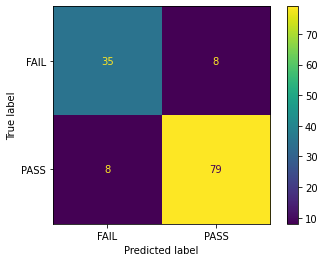

              precision    recall  f1-score   support

        FAIL       0.80      0.81      0.80       130
        PASS       0.91      0.90      0.90       265

    accuracy                           0.87       395
   macro avg       0.85      0.85      0.85       395
weighted avg       0.87      0.87      0.87       395



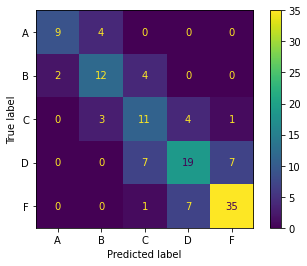

              precision    recall  f1-score   support

           A       0.78      0.70      0.74        40
           B       0.61      0.60      0.61        60
           C       0.47      0.56      0.51        62
           D       0.62      0.56      0.59       103
           F       0.81      0.82      0.81       130

    accuracy                           0.67       395
   macro avg       0.66      0.65      0.65       395
weighted avg       0.67      0.67      0.67       395



In [6]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

    random_forest_bin = RandomForestClassifier()
    random_forest_5l  = RandomForestClassifier()

    random_forest_bin = random_forest_bin.fit(X_train, y_binary_train)
    random_forest_5l  = random_forest_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = random_forest_bin.predict(X_test)
    y_5_level_pred = random_forest_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_5l.classes_).plot()
plt.show()
print(report)



# without PCA + Random Forest
    這邊我使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為Random Forest"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。

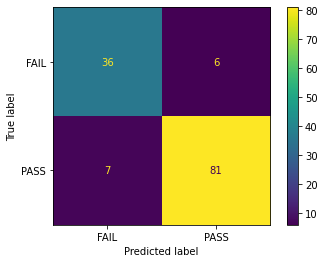

              precision    recall  f1-score   support

        FAIL       0.84      0.85      0.84       130
        PASS       0.92      0.92      0.92       265

    accuracy                           0.90       395
   macro avg       0.88      0.88      0.88       395
weighted avg       0.90      0.90      0.90       395



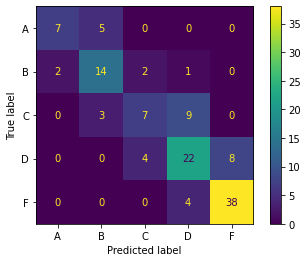

              precision    recall  f1-score   support

           A       0.76      0.55      0.64        40
           B       0.63      0.70      0.66        60
           C       0.51      0.37      0.43        62
           D       0.59      0.65      0.62       103
           F       0.82      0.89      0.86       130

    accuracy                           0.68       395
   macro avg       0.66      0.63      0.64       395
weighted avg       0.68      0.68      0.68       395



In [7]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    random_forest_bin = RandomForestClassifier()
    random_forest_5l  = RandomForestClassifier()

    random_forest_bin = random_forest_bin.fit(X_train, y_binary_train)
    random_forest_5l  = random_forest_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = random_forest_bin.predict(X_test)
    y_5_level_pred = random_forest_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_5l.classes_).plot()
plt.show()
print(report)



# Random Forest with 3 different numbers of trees
    這邊我使用了3種不同大小的Random Forest針對每一種不同的Random Forest我都使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為Random Forest"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。
    可以看到隨著樹的數量的上升，5LEVEL的分類準確率也逐步上升，但BINARY卻沒有太大改變

Random Forest with 5 trees


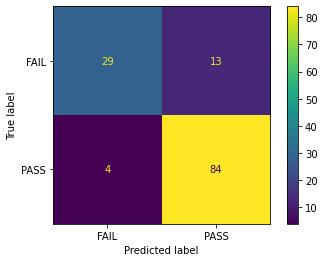

              precision    recall  f1-score   support

        FAIL       0.87      0.68      0.77       130
        PASS       0.86      0.95      0.90       265

    accuracy                           0.86       395
   macro avg       0.87      0.82      0.84       395
weighted avg       0.86      0.86      0.86       395



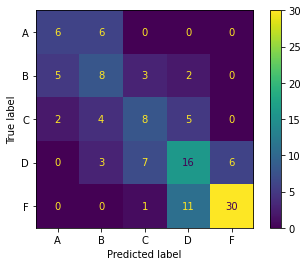

              precision    recall  f1-score   support

           A       0.43      0.45      0.44        40
           B       0.38      0.43      0.40        60
           C       0.42      0.42      0.42        62
           D       0.45      0.48      0.46       103
           F       0.81      0.71      0.76       130

    accuracy                           0.53       395
   macro avg       0.50      0.50      0.50       395
weighted avg       0.55      0.53      0.54       395

Random Forest with 10 trees


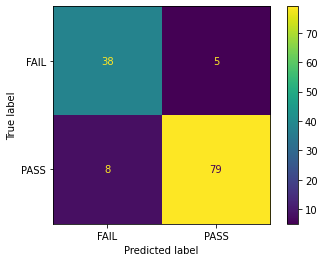

              precision    recall  f1-score   support

        FAIL       0.81      0.88      0.84       130
        PASS       0.94      0.90      0.92       265

    accuracy                           0.89       395
   macro avg       0.88      0.89      0.88       395
weighted avg       0.90      0.89      0.89       395



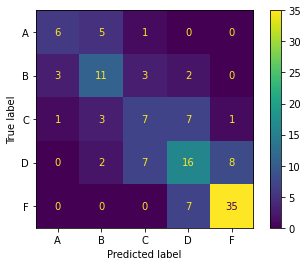

              precision    recall  f1-score   support

           A       0.56      0.45      0.50        40
           B       0.49      0.55      0.52        60
           C       0.40      0.37      0.38        62
           D       0.48      0.47      0.47       103
           F       0.77      0.82      0.79       130

    accuracy                           0.58       395
   macro avg       0.54      0.53      0.53       395
weighted avg       0.57      0.58      0.57       395

Random Forest with 50 trees


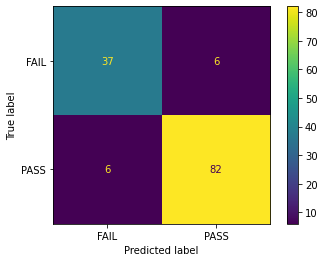

              precision    recall  f1-score   support

        FAIL       0.86      0.85      0.86       130
        PASS       0.93      0.93      0.93       265

    accuracy                           0.91       395
   macro avg       0.89      0.89      0.89       395
weighted avg       0.91      0.91      0.91       395



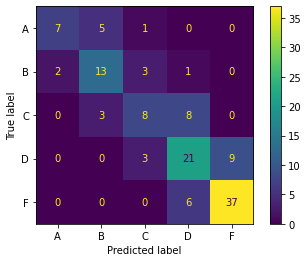

              precision    recall  f1-score   support

           A       0.72      0.53      0.61        40
           B       0.59      0.65      0.62        60
           C       0.55      0.42      0.48        62
           D       0.57      0.61      0.59       103
           F       0.78      0.86      0.82       130

    accuracy                           0.66       395
   macro avg       0.64      0.61      0.62       395
weighted avg       0.66      0.66      0.65       395



In [8]:
for tree_num in [5, 10, 50]:
    kf = KFold(n_splits=3)
    kf.get_n_splits(x)
    true_bin_class = []
    true_5l_class = []
    pred_bin_class = []
    pred_5l_class = []

    CMbinary_list = np.zeros((2,2)).astype(int)
    CM5_level_list = np.zeros((5,5)).astype(int)

    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
        y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

        random_forest_bin = RandomForestClassifier(tree_num)
        random_forest_5l  = RandomForestClassifier(tree_num)

        random_forest_bin = random_forest_bin.fit(X_train, y_binary_train)
        random_forest_5l  = random_forest_5l.fit(X_train, y_5_level_train)

        y_binary_pred  = random_forest_bin.predict(X_test)
        y_5_level_pred = random_forest_5l.predict(X_test)

        true_bin_class.extend(y_binary_test)
        true_5l_class.extend(y_5_level_test)
        pred_bin_class.extend(y_binary_pred)
        pred_5l_class.extend(y_5_level_pred)
    
    print(f"Random Forest with {tree_num} trees")
    #binary 
    CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
    report = classification_report(true_bin_class, pred_bin_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_bin.classes_).plot()
    plt.show()
    print(report)

    #5 level 
    CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
    report = classification_report(true_5l_class, pred_5l_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=random_forest_5l.classes_).plot()
    plt.show()
    print(report)



# PCA + KNN 
    這邊我使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為PCA以及KNN"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。

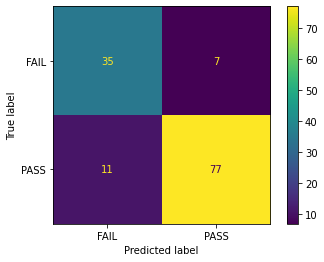

              precision    recall  f1-score   support

        FAIL       0.76      0.82      0.79       130
        PASS       0.91      0.88      0.89       265

    accuracy                           0.86       395
   macro avg       0.84      0.85      0.84       395
weighted avg       0.86      0.86      0.86       395



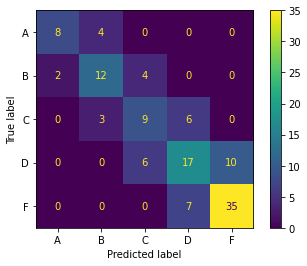

              precision    recall  f1-score   support

           A       0.76      0.65      0.70        40
           B       0.62      0.63      0.63        60
           C       0.45      0.47      0.46        62
           D       0.54      0.50      0.52       103
           F       0.76      0.82      0.79       130

    accuracy                           0.64       395
   macro avg       0.63      0.62      0.62       395
weighted avg       0.64      0.64      0.64       395



In [9]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test  = pca.transform(X_test)

    KNN_bin = KNeighborsClassifier(n_neighbors=5)
    KNN_5l  = KNeighborsClassifier(n_neighbors=5)

    KNN_bin = KNN_bin.fit(X_train, y_binary_train)
    KNN_5l  = KNN_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = KNN_bin.predict(X_test)
    y_5_level_pred = KNN_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_5l.classes_).plot()
plt.show()
print(report)



# without PCA + KNN 
    這邊我使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為KNN"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。

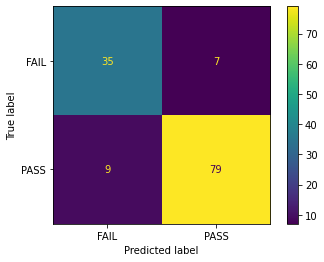

              precision    recall  f1-score   support

        FAIL       0.80      0.82      0.81       130
        PASS       0.91      0.90      0.90       265

    accuracy                           0.87       395
   macro avg       0.86      0.86      0.86       395
weighted avg       0.87      0.87      0.87       395



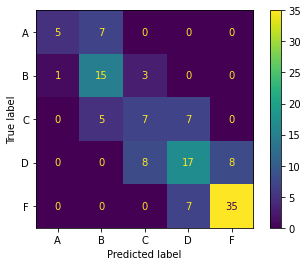

              precision    recall  f1-score   support

           A       0.85      0.42      0.57        40
           B       0.54      0.77      0.63        60
           C       0.39      0.37      0.38        62
           D       0.53      0.50      0.51       103
           F       0.80      0.82      0.81       130

    accuracy                           0.62       395
   macro avg       0.62      0.58      0.58       395
weighted avg       0.63      0.62      0.61       395



In [10]:
kf = KFold(n_splits=3)
kf.get_n_splits(x)
true_bin_class = []
true_5l_class = []
pred_bin_class = []
pred_5l_class = []

CMbinary_list = np.zeros((2,2)).astype(int)
CM5_level_list = np.zeros((5,5)).astype(int)

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
    y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

    KNN_bin = KNeighborsClassifier(n_neighbors=5)
    KNN_5l  = KNeighborsClassifier(n_neighbors=5)

    KNN_bin = KNN_bin.fit(X_train, y_binary_train)
    KNN_5l  = KNN_5l.fit(X_train, y_5_level_train)

    y_binary_pred  = KNN_bin.predict(X_test)
    y_5_level_pred = KNN_5l.predict(X_test)

    true_bin_class.extend(y_binary_test)
    true_5l_class.extend(y_5_level_test)
    pred_bin_class.extend(y_binary_pred)
    pred_5l_class.extend(y_5_level_pred)

#binary 
CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
report = classification_report(true_bin_class, pred_bin_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_bin.classes_).plot()
plt.show()
print(report)

#5 level 
CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
report = classification_report(true_5l_class, pred_5l_class)
ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_5l.classes_).plot()
plt.show()
print(report)



# KNN with 3 different K values
    這邊我使用了3種不同的K value，針對每一種不同的KNN我都使用了3-fold cross-validation來取平均，在每一輪當中，我會先使用該輪的訓練資料去為Random Forest"重新"做fitting，然後再將測試資料丟入進行驗證。最後印出Confusion matrix以及各項性能指標的報告出來。
    可以看到隨著K的上升，5LEVEL的分類準確率也逐步上升，但BINARY卻沒有太大改變

KNN with 5 neighbors


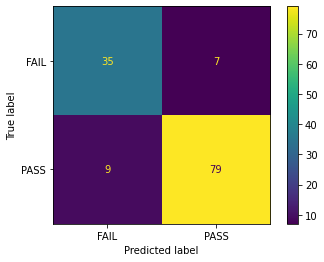

              precision    recall  f1-score   support

        FAIL       0.80      0.82      0.81       130
        PASS       0.91      0.90      0.90       265

    accuracy                           0.87       395
   macro avg       0.86      0.86      0.86       395
weighted avg       0.87      0.87      0.87       395



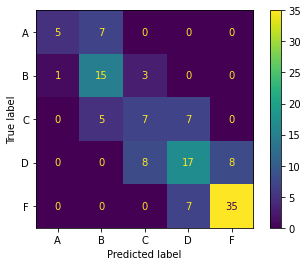

              precision    recall  f1-score   support

           A       0.85      0.42      0.57        40
           B       0.54      0.77      0.63        60
           C       0.39      0.37      0.38        62
           D       0.53      0.50      0.51       103
           F       0.80      0.82      0.81       130

    accuracy                           0.62       395
   macro avg       0.62      0.58      0.58       395
weighted avg       0.63      0.62      0.61       395

KNN with 10 neighbors


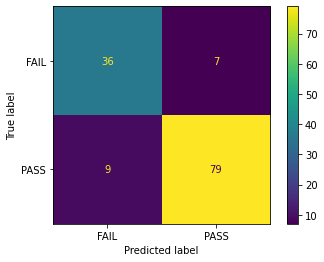

              precision    recall  f1-score   support

        FAIL       0.79      0.83      0.81       130
        PASS       0.92      0.89      0.90       265

    accuracy                           0.87       395
   macro avg       0.85      0.86      0.86       395
weighted avg       0.88      0.87      0.87       395



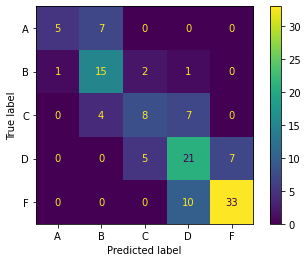

              precision    recall  f1-score   support

           A       0.81      0.42      0.56        40
           B       0.56      0.75      0.64        60
           C       0.52      0.42      0.46        62
           D       0.52      0.61      0.56       103
           F       0.81      0.77      0.79       130

    accuracy                           0.64       395
   macro avg       0.65      0.60      0.60       395
weighted avg       0.65      0.64      0.63       395

KNN with 20 neighbors


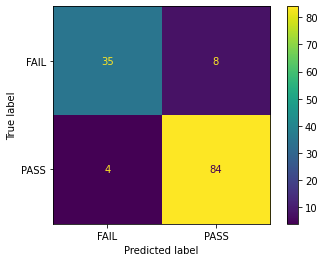

              precision    recall  f1-score   support

        FAIL       0.89      0.81      0.85       130
        PASS       0.91      0.95      0.93       265

    accuracy                           0.90       395
   macro avg       0.90      0.88      0.89       395
weighted avg       0.90      0.90      0.90       395



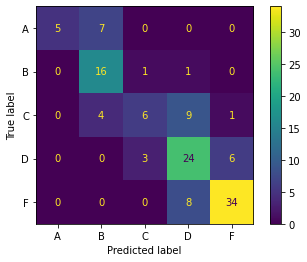

              precision    recall  f1-score   support

           A       0.89      0.42      0.58        40
           B       0.59      0.83      0.69        60
           C       0.54      0.31      0.39        62
           D       0.55      0.70      0.62       103
           F       0.83      0.80      0.82       130

    accuracy                           0.66       395
   macro avg       0.68      0.61      0.62       395
weighted avg       0.68      0.66      0.65       395



In [11]:
for k in [5, 10, 20]:
    kf = KFold(n_splits=3)
    kf.get_n_splits(x)
    true_bin_class = []
    true_5l_class = []
    pred_bin_class = []
    pred_5l_class = []

    CMbinary_list = np.zeros((2,2)).astype(int)
    CM5_level_list = np.zeros((5,5)).astype(int)

    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_binary_train, y_binary_test = y_binary[train_index], y_binary[test_index]
        y_5_level_train, y_5_level_test = y_5_level[train_index], y_5_level[test_index]

        KNN_bin = KNeighborsClassifier(n_neighbors=k)
        KNN_5l  = KNeighborsClassifier(n_neighbors=k)

        KNN_bin = KNN_bin.fit(X_train, y_binary_train)
        KNN_5l  = KNN_5l.fit(X_train, y_5_level_train)

        y_binary_pred  = KNN_bin.predict(X_test)
        y_5_level_pred = KNN_5l.predict(X_test)

        true_bin_class.extend(y_binary_test)
        true_5l_class.extend(y_5_level_test)
        pred_bin_class.extend(y_binary_pred)
        pred_5l_class.extend(y_5_level_pred)

    print(f"KNN with {k} neighbors")
    #binary 
    CMbinary_list = confusion_matrix(true_bin_class, pred_bin_class) // 3
    report = classification_report(true_bin_class, pred_bin_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_bin.classes_).plot()
    plt.show()
    print(report)

    #5 level 
    CMbinary_list = confusion_matrix(true_5l_class, pred_5l_class) // 3
    report = classification_report(true_5l_class, pred_5l_class)
    ConfusionMatrixDisplay(confusion_matrix=CMbinary_list, display_labels=KNN_5l.classes_).plot()
    plt.show()
    print(report)



# Question

## Decision Tree: Show the prediction and reasoning of one arbitrary sample in the testing set.
    在這邊，我將第0筆資料做為測試集，剩餘其他的作為訓練集

data x[0]:  [[ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.
   1.  0.  1.  1.  0.  1.  0. 18.  4.  4.  2.  2.  0.  4.  3.  4.  1.  1.
   3.  6.  5.  6.]]
Rules used to predict x[0]:
decision node 0 : (X_test[0, 57] = 10.0) > 9.5)
decision node 44 : (X_test[0, 56] = 9.0) <= 10.5)
decision node 45 : (X_test[0, 43] = 18.0) > 17.5)
decision node 57 : (X_test[0, 55] = 0.0) <= 1.5)
The Decision Tree model predict x[0] to FAIL



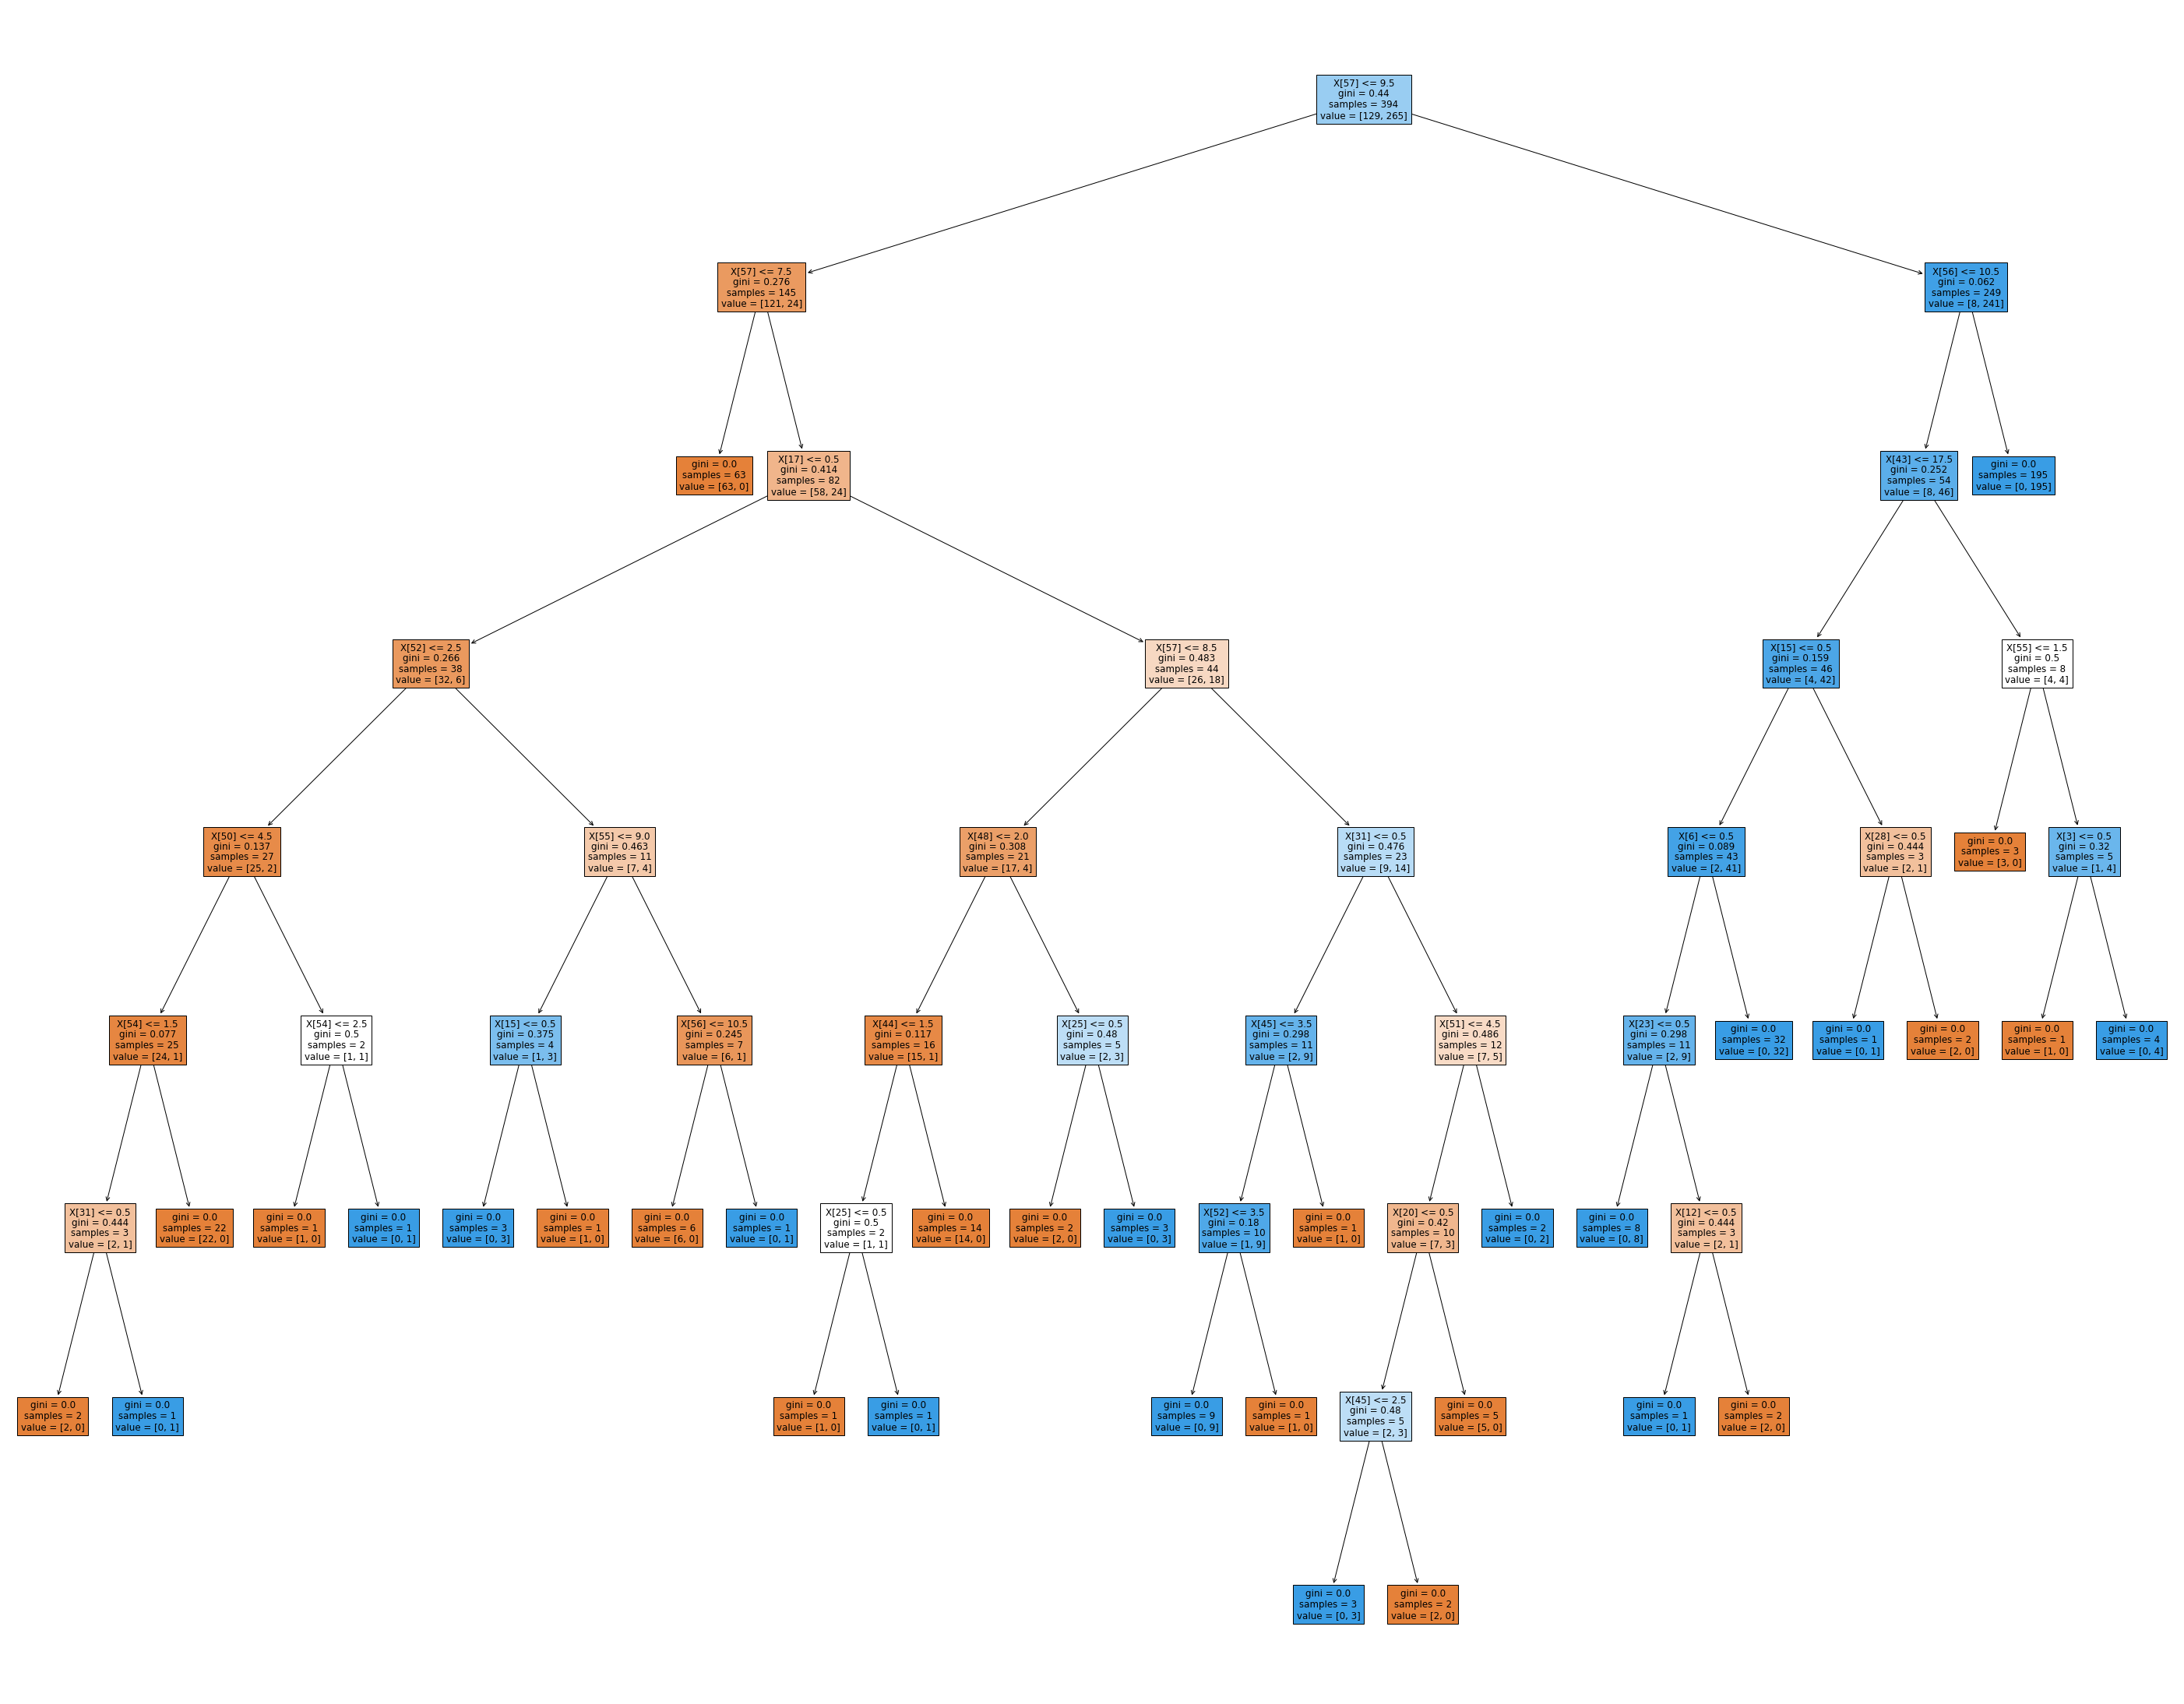

In [12]:
decision_tree_bin = tree.DecisionTreeClassifier()
decision_tree_bin = decision_tree_bin.fit(x[1:], y_binary[1:])
data = x[0].reshape(1, -1)
print("data x[0]: ", data)
y_pred  = decision_tree_bin.predict(data)
fig = plt.figure(figsize=(50,40))
tree.plot_tree(decision_tree_bin,filled=True)


node_indicator = decision_tree_bin.decision_path(X_test)
leaf_id = decision_tree_bin.apply(X_test)
feature = decision_tree_bin.tree_.feature
threshold = decision_tree_bin.tree_.threshold
sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict x[0]:")
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )
print(f"The Decision Tree model predict x[0] to {y_pred[0]}\n")
plt.show()

## Describe the difference between boosting and bagging.
    Bagging指的是訓練集當中隨機抽取多個小數量的資料去訓練多個複雜模型，在進行預測的時候，這些模型去進行投票(classification)或取平均(regression)
    Boosting則是使用多個弱分類器來進行合成，首先會先挑出一個最佳的分類器，並在剩下的弱分類器中找出與前面的分類器互補的，這樣的步驟會持續多次直到準確率足夠
    一般來說，bagging適合用在容易overfitting的模型，boosting適合用在underfitting的模型
    
## KNN: Show the prediction and reasoning of one arbitrary sample in the testing set.
    在這邊，我將第0筆資料做為測試集，剩餘其他的作為訓練集

In [13]:
KNN_bin = KNeighborsClassifier(n_neighbors=20)
KNN_bin = KNN_bin.fit(x[1:], y_binary[1:])

data = x[0].reshape(1, -1)
y_pred = KNN_bin.predict(data)
print(f"The KNN model predict x[0] to {y_pred[0]}\n")
y_pred = KNN_bin.kneighbors(data)
for idx in range(len(y_pred[0][0])):
    print(f"The distance between input data x[0] and the {idx+1}-th closet neighbor(x[{y_pred[1][0][idx]}]) is {y_pred[0][0][idx]}, with label {y_binary[y_pred[1][0][idx]+1]}")


The KNN model predict x[0] to FAIL

The distance between input data x[0] and the 1-th closet neighbor(x[6]) is 4.123105625617661, with label FAIL
The distance between input data x[0] and the 2-th closet neighbor(x[208]) is 6.0, with label FAIL
The distance between input data x[0] and the 3-th closet neighbor(x[187]) is 6.0, with label FAIL
The distance between input data x[0] and the 4-th closet neighbor(x[385]) is 6.082762530298219, with label FAIL
The distance between input data x[0] and the 5-th closet neighbor(x[85]) is 6.244997998398398, with label FAIL
The distance between input data x[0] and the 6-th closet neighbor(x[176]) is 6.324555320336759, with label FAIL
The distance between input data x[0] and the 7-th closet neighbor(x[0]) is 6.4031242374328485, with label FAIL
The distance between input data x[0] and the 8-th closet neighbor(x[247]) is 6.48074069840786, with label FAIL
The distance between input data x[0] and the 9-th closet neighbor(x[91]) is 6.708203932499369, with l

## Bonus: pick 2 features, draw and describe the KNN decision boundaries
    這邊我僅保留了最後兩項的feature(G1與G2)來做KNN並畫圖

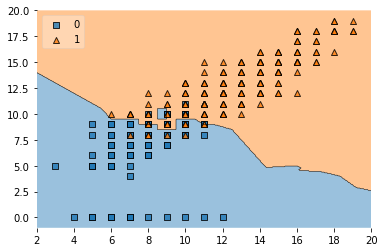

In [14]:
from mlxtend.plotting import plot_decision_regions

x_bonus = x
y_bonus = []
for i in range(56): 
    x_bonus = np.delete(x_bonus, 0, 1)
for label in y_binary:
    if label == 'PASS':
        y_bonus.append(1)
    else:
        y_bonus.append(0)
y_bonus = np.array(y_bonus)

KNN_bin = KNeighborsClassifier(n_neighbors=5)
KNN_bin = KNN_bin.fit(x_bonus, y_bonus)
plot_decision_regions(x_bonus, y_bonus, clf=KNN_bin, legend=2)
plt.show()

## In 5-Level classification, reduce the data dimension to 2 using PCA and draw a scatter plot. You have to colorize the data points based on their labels.

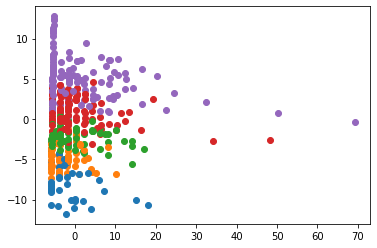

In [15]:
pca = PCA(n_components=2)
pca.fit(x)
x_q4 = pca.transform(x)
for idx in range(len(x_q4)):
    if y_5_level[idx] == 'A':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#1f77b4')
    elif y_5_level[idx] == 'B':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#ff7f0e')
    elif y_5_level[idx] == 'C':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#2ca02c')
    elif y_5_level[idx] == 'D':
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#d62728')
    else:
        plt.scatter(x_q4[idx][0], x_q4[idx][1], c = '#9467bd')
plt.show()